<a href="https://colab.research.google.com/github/windopper/NerualNetworkPracticeInJupyter/blob/main/RecurrentNeuralNetwork/text_generation_using_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RNN을 이용한 텍스트 생성

데이터 전처리 과정

reference https://wikidocs.net/45101

In [1]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

text = """경마장에 있는 말이 뛰고 있다\n
그의 말이 법이다\n
가는 말이 고와야 오는 말이 곱다\n"""

tokenizer = Tokenizer()
tokenizer.fit_on_texts([text])
vocab_size = len(tokenizer.word_index)+1
print('단어 집합의 크기 : %d' %vocab_size)

단어 집합의 크기 : 12


In [2]:
print(tokenizer.word_index)

{'말이': 1, '경마장에': 2, '있는': 3, '뛰고': 4, '있다': 5, '그의': 6, '법이다': 7, '가는': 8, '고와야': 9, '오는': 10, '곱다': 11}


In [3]:
sequences = list()
for line in text.split("\n"):
  encoded = tokenizer.texts_to_sequences([line])[0]
  for i in range(1, len(encoded)):
    sequence = encoded[:i+1]
    sequences.append(sequence)

print('학습에 사용할 샘플의 개수: %d' % len(sequences))
print(sequences)

학습에 사용할 샘플의 개수: 11
[[2, 3], [2, 3, 1], [2, 3, 1, 4], [2, 3, 1, 4, 5], [6, 1], [6, 1, 7], [8, 1], [8, 1, 9], [8, 1, 9, 10], [8, 1, 9, 10, 1], [8, 1, 9, 10, 1, 11]]


In [4]:
max_len = max(len(l) for l in sequences)
print('샘플의 최대 길이 : ', max_len)

샘플의 최대 길이 :  6


In [5]:
sequences = pad_sequences(sequences, maxlen=max_len, padding='pre')
print(sequences)

[[ 0  0  0  0  2  3]
 [ 0  0  0  2  3  1]
 [ 0  0  2  3  1  4]
 [ 0  2  3  1  4  5]
 [ 0  0  0  0  6  1]
 [ 0  0  0  6  1  7]
 [ 0  0  0  0  8  1]
 [ 0  0  0  8  1  9]
 [ 0  0  8  1  9 10]
 [ 0  8  1  9 10  1]
 [ 8  1  9 10  1 11]]


레이블 분리

In [6]:
sequences = np.array(sequences)
x = sequences[:, :-1]
y = sequences[:, -1]

print(x)

[[ 0  0  0  0  2]
 [ 0  0  0  2  3]
 [ 0  0  2  3  1]
 [ 0  2  3  1  4]
 [ 0  0  0  0  6]
 [ 0  0  0  6  1]
 [ 0  0  0  0  8]
 [ 0  0  0  8  1]
 [ 0  0  8  1  9]
 [ 0  8  1  9 10]
 [ 8  1  9 10  1]]


In [7]:
print(y)

[ 3  1  4  5  1  7  1  9 10  1 11]


레이블 분리 완료

레이블에 대해서 원-핫 인코딩 수행

In [8]:
y = to_categorical(y, num_classes=vocab_size)
print(y)

[[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


# 모델 설계하기

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, SimpleRNN


하이퍼파라미터인 임베딩 벡터의 차원은 10, 은닉 상태의 크기는 32임. 다대일 구조의 RNN을 사용하고 전결합층(FCL)을 출력층으로 단어 집합 크기 만큼의 뉴런을 배치하여 모델을 설계.

해당 모델은 마지막 시점에 가능한 단어 중 하나를 예측하는 멀티 클래스 분류 문제 이므로, 출력층에 소프트 맥스 회귀를 사용하고 손실함수로 카테고리얼 크로스 엔트로피 함수를 사용함

In [22]:
embedding_dim = 10
hidden_units = 32

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(SimpleRNN(hidden_units))
model.add(Dense(vocab_size, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(x, y, epochs=200, verbose=2)

Epoch 1/200
1/1 - 3s - loss: 2.4587 - accuracy: 0.0909 - 3s/epoch - 3s/step
Epoch 2/200
1/1 - 0s - loss: 2.4441 - accuracy: 0.3636 - 53ms/epoch - 53ms/step
Epoch 3/200
1/1 - 0s - loss: 2.4294 - accuracy: 0.3636 - 20ms/epoch - 20ms/step
Epoch 4/200
1/1 - 0s - loss: 2.4146 - accuracy: 0.3636 - 26ms/epoch - 26ms/step
Epoch 5/200
1/1 - 0s - loss: 2.3995 - accuracy: 0.3636 - 28ms/epoch - 28ms/step
Epoch 6/200
1/1 - 0s - loss: 2.3841 - accuracy: 0.3636 - 21ms/epoch - 21ms/step
Epoch 7/200
1/1 - 0s - loss: 2.3684 - accuracy: 0.3636 - 42ms/epoch - 42ms/step
Epoch 8/200
1/1 - 0s - loss: 2.3521 - accuracy: 0.3636 - 22ms/epoch - 22ms/step
Epoch 9/200
1/1 - 0s - loss: 2.3354 - accuracy: 0.3636 - 28ms/epoch - 28ms/step
Epoch 10/200
1/1 - 0s - loss: 2.3181 - accuracy: 0.3636 - 20ms/epoch - 20ms/step
Epoch 11/200
1/1 - 0s - loss: 2.3002 - accuracy: 0.3636 - 24ms/epoch - 24ms/step
Epoch 12/200
1/1 - 0s - loss: 2.2817 - accuracy: 0.3636 - 30ms/epoch - 30ms/step
Epoch 13/200
1/1 - 0s - loss: 2.2625 - ac

In [15]:
def sentence_generation(model, tokenizer, current_word, n): # 모델 토크나이저 현재 단어 반복할 회수
  init_word = current_word
  sentence = ''

  for _ in range(n):
    encoded = tokenizer.texts_to_sequences([current_word])[0]
    encoded = pad_sequences([encoded], maxlen=5, padding='pre')
    result = model.predict(encoded, verbose=0)
    result = np.argmax(result, axis=1)

    for word, index in tokenizer.word_index.items():
      if index == result:
        break

    current_word = current_word + ' ' + word
    sentence = sentence + ' ' + word
  sentence = init_word + sentence
  return sentence

In [16]:
print(sentence_generation(model, tokenizer, '경마장에', 4))

경마장에 있는 말이 뛰고 있다


In [17]:
print(sentence_generation(model, tokenizer, '그의', 2))

그의 말이 법이다


In [18]:
print(sentence_generation(model, tokenizer, '가는', 5))

가는 말이 고와야 오는 말이 곱다


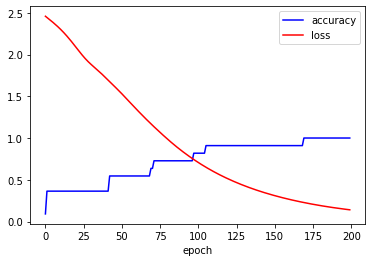

In [34]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], 'b-', label='accuracy')
plt.plot(history.history['loss'], 'r-', label='loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

# LSTM을 이용하여 텍스트 생성하기

뉴욕 타임즈 기사 데이터 사용하기

In [37]:
import pandas as pd
import numpy as np
from string import punctuation
from google.colab import files

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

upload = files.upload()

Saving ArticlesApril2018.csv to ArticlesApril2018.csv


In [39]:
df = pd.read_csv('ArticlesApril2018.csv')
df.head()

,articleID,articleWordCount,byline,documentType,headline,keywords,multimedia,newDesk,printPage,pubDate,sectionName,snippet,source,typeOfMaterial,webURL
0,5adf6684068401528a2aa69b,781,By JOHN BRANCH,article,Former N.F.L. Cheerleaders’ Settlement Offer: ...,"['Workplace Hazards and Violations', 'Football...",68,Sports,0,2018-04-24 17:16:49,Pro Football,"“I understand that they could meet with us, pa...",The New York Times,News,https://www.nytimes.com/2018/04/24/sports/foot...
1,5adf653f068401528a2aa697,656,By LISA FRIEDMAN,article,E.P.A. to Unveil a New Rule. Its Effect: Less ...,"['Environmental Protection Agency', 'Pruitt, S...",68,Climate,0,2018-04-24 17:11:21,Unknown,The agency plans to publish a new regulation T...,The New York Times,News,https://www.nytimes.com/2018/04/24/climate/epa...
2,5adf4626068401528a2aa628,2427,By PETE WELLS,article,"The New Noma, Explained","['Restaurants', 'Noma (Copenhagen, Restaurant)...",66,Dining,0,2018-04-24 14:58:44,Unknown,What’s it like to eat at the second incarnatio...,The New York Times,News,https://www.nytimes.com/2018/04/24/dining/noma...
3,5adf40d2068401528a2aa619,626,By JULIE HIRSCHFELD DAVIS and PETER BAKER,article,Unknown,"['Macron, Emmanuel (1977- )', 'Trump, Donald J...",68,Washington,0,2018-04-24 14:35:57,Europe,President Trump welcomed President Emmanuel Ma...,The New York Times,News,https://www.nytimes.com/2018/04/24/world/europ...
4,5adf3d64068401528a2aa60f,815,By IAN AUSTEN and DAN BILEFSKY,article,Unknown,"['Toronto, Ontario, Attack (April, 2018)', 'Mu...",68,Foreign,0,2018-04-24 14:21:21,Canada,"Alek Minassian, 25, a resident of Toronto’s Ri...",The New York Times,News,https://www.nytimes.com/2018/04/24/world/canad...


In [41]:
print('열의 개수 : ', len(df.columns))
print(df.columns)

열의 개수 :  15
Index(['articleID', 'articleWordCount', 'byline', 'documentType', 'headline',
       'keywords', 'multimedia', 'newDesk', 'printPage', 'pubDate',
       'sectionName', 'snippet', 'source', 'typeOfMaterial', 'webURL'],
      dtype='object')


In [42]:
print(df['headline'].isnull().values.any())

False


헤드라인을 별도의 리스트로 저장

In [44]:
headline = []

headline.extend(list(df.headline.values))
headline[:5]

['Former N.F.L. Cheerleaders’ Settlement Offer: $1 and a Meeting With Goodell',
 'E.P.A. to Unveil a New Rule. Its Effect: Less Science in Policymaking.',
 'The New Noma, Explained',
 'Unknown',
 'Unknown']

headline 전체에 unknown 값이 들어간 샘플이 있는 것으로 파악되어 그 노이즈데이터를 제거해줄 필요가 있음

In [48]:
print(len(headline))

1324


In [52]:
headline = [ word for word in headline if word != "Unknown"]
print(len(headline))
headline[:5]

1214


['Former N.F.L. Cheerleaders’ Settlement Offer: $1 and a Meeting With Goodell',
 'E.P.A. to Unveil a New Rule. Its Effect: Less Science in Policymaking.',
 'The New Noma, Explained',
 'How a Bag of Texas Dirt  Became a Times Tradition',
 'Is School a Place for Self-Expression?']

110개의 샘플이 제거됨

전처리 수행 작업

구두점 제거과 단어의 소문자화를 시행

In [51]:
def repreprocessing(raw_sentence):
  preprocessed_sentence = raw_sentence.encode('utf-8').decode('ascii', 'ignore')
  return ''.join(word for word in preprocessed_sentence if word not in punctuation).lower()

preprocessed_headline = [repreprocessing(x) for x in headline]
preprocessed_headline[:5]

['former nfl cheerleaders settlement offer 1 and a meeting with goodell',
 'epa to unveil a new rule its effect less science in policymaking',
 'the new noma explained',
 'how a bag of texas dirt  became a times tradition',
 'is school a place for selfexpression']

이전과 비교하면 모든 단어들이 소문자화 되었으면 N.F.L이나 Cheerleaders' 와 같이 구두점이 들어있었던 단어들에서 구두점이 제거됨

이제 단어 집합을 만들면

In [53]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(preprocessed_headline)
vocab_size = len(tokenizer.index_word) + 1
print('단어 집합의 크기 : ', vocab_size)

단어 집합의 크기 :  3494


정수 인코딩을 진행하는 동시에 문장을 여러줄로 분해하여 훈련 데이터 구성

In [56]:
sequences = list()

for sentence in preprocessed_headline:
  encoded = tokenizer.texts_to_sequences([sentence])[0]
  for i in range(1, len(encoded)):
    sequence = encoded[:i+1]
    sequences.append(sequence)

sequences[:11]

[[99, 269],
 [99, 269, 371],
 [99, 269, 371, 1115],
 [99, 269, 371, 1115, 582],
 [99, 269, 371, 1115, 582, 52],
 [99, 269, 371, 1115, 582, 52, 7],
 [99, 269, 371, 1115, 582, 52, 7, 2],
 [99, 269, 371, 1115, 582, 52, 7, 2, 372],
 [99, 269, 371, 1115, 582, 52, 7, 2, 372, 10],
 [99, 269, 371, 1115, 582, 52, 7, 2, 372, 10, 1116],
 [100, 3]]

인덱스를 단어로 바꾸기 위한 index_to_word를 만들면

In [57]:
index_to_word = {}

for key, value in tokenizer.word_index.items():
  index_to_word[value] = key

print('빈도수 상위 582번 단어 : {}'.format(index_to_word[582]))

빈도수 상위 582번 단어 : offer


전체 샘플의 길이를 동일하게 맞추는 패딩 작업을 시행

In [58]:
max_len = max(len(l) for l in sequences)
print('샘플의 최대 길이 : ', max_len)

샘플의 최대 길이 :  24


In [59]:
sequences = pad_sequences(sequences, maxlen=max_len, padding='pre')
print(sequences[:5])

[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0   99  269]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0   99  269  371]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0   99  269  371 1115]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0   99  269  371 1115  582]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0   99  269  371 1115  582   52]]


맨 우측 단어만 레이블로 분리하면

In [60]:
sequences = np.array(sequences)
x = sequences[:, :-1]
y = sequences[:, -1]

print(x[:5])
print(y[:5])

[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0   99]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0   99  269]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0   99  269  371]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0   99  269  371 1115]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0   99  269  371 1115  582]]
[ 269  371 1115  582   52]


y 레이블에 대해서 원-핫 인코딩 수행

In [61]:
y = to_categorical(y, num_classes=vocab_size)